# TEST Simple Supervised Learning. Regression

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## 1. Data Processing

In [2]:
data_size = 500
x = np.linspace(0, 200, data_size)

y = np.array([-i * i + 1200 for i in np.linspace(-50, 50, num=data_size)])
y = y + np.random.normal(0,100,data_size) # add noise

df = pd.DataFrame({'x': x, 'y': y})
target = ['y']

print("rows: {} \ncolumns: {} \ntarget: {}".format(*df.shape, target))
df.head(5)

rows: 500 
columns: 2 
target: ['y']


,x,y
0,0.000000,-1381.428911
1,0.400802,-1396.060359
2,0.801603,-1210.177852
3,1.202405,-1388.686334
4,1.603206,-1036.758221


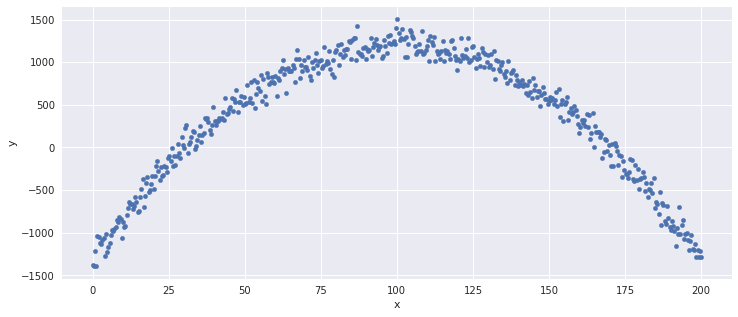

In [3]:
df.plot.scatter(x='x', y='y', figsize=(12,5));

#### Correlation between numerical features and target

In [4]:
df.corr()

,x,y
x,1.000000,0.000173
y,0.000173,1.000000


## 2. Neural Network model

In [5]:
from sklearn.model_selection import train_test_split

data = df.copy()

# Standarize x & y
scale = {} 

for col in data:
    mean, std = data[col].mean(), data[col].std()
    data[col] = (data[col] - mean) / std
    scale[col] = [mean, std]

test_size = 0

train, test = train_test_split(data, test_size=test_size, random_state=9, shuffle=True)
x_train, y_train = train.drop(target, axis=1).values, train[target].values


### Build and train the Neural Network

Using TensorFlow backend.


time: 	 10.3 s


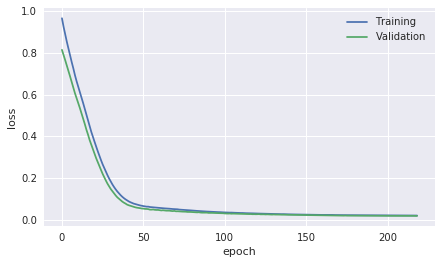

In [6]:
from time import time
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout

#weights = keras.initializers.RandomNormal(stddev=0.01)

model = Sequential()

model.add(Dense(8, input_dim=1, activation='relu'))

model.add(Dense(1, activation=None))

model.compile(loss='mean_squared_error', optimizer='adam')


callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0)]
t0 = time()

history = model.fit(x_train, y_train, epochs=1000, batch_size=16, 
                    validation_split=0.25, callbacks=callbacks, verbose=0)

print("time: \t {:.1f} s".format(time() - t0))

hist = history.history

plt.figure(figsize=(7, 4))
plt.plot(hist['loss'], label='Training')
if 'val_loss' in hist:
    plt.plot(hist['val_loss'], label='Validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend();

### Check the model

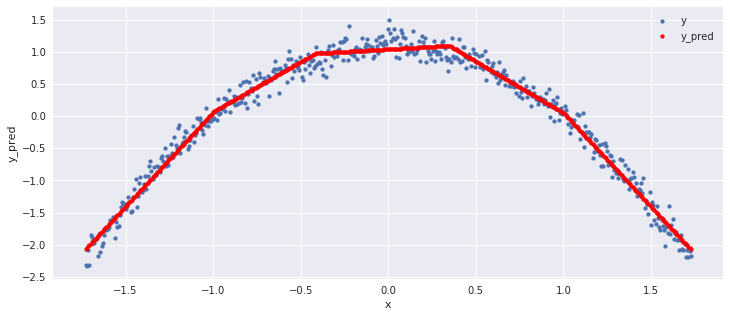

In [7]:
x_test = data.drop(target, axis=1).values

pred = model.predict(x_test, verbose=0)

df_pred = data.copy()
df_pred['y_pred'] = pred

ax = df_pred.plot.scatter('x', 'y', figsize=(12, 5), s=15, label='y')
df_pred.plot.scatter('x', 'y_pred', ax=ax, c='r', s=15, label='y_pred');

### Compare with non-neural network models

#### XGBoost

Training Time:  	 0.011 s


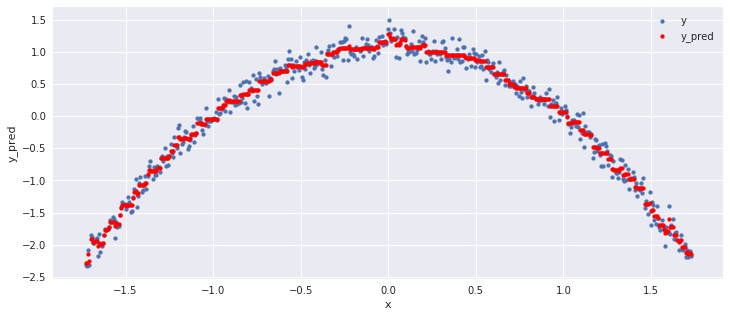

In [11]:
from time import time
import xgboost as xgb

reg=None
reg = xgb.XGBRegressor()

t0 = time()

reg.fit(x_train, y_train[:, 0])
train_time = time() - t0

print("Training Time:  \t {:.3f} s".format(train_time))

y_pred = reg.predict(x_test)

df_pred2 = data.copy()
df_pred2['y_pred'] = y_pred

ax = df_pred2.plot.scatter('x', 'y', figsize=(12, 5), s=15, label='y')
df_pred2.plot.scatter('x', 'y_pred', ax=ax, c='r', s=15, label='y_pred');

#### Classical Machine Learning

Training Time:  	 0.011 s


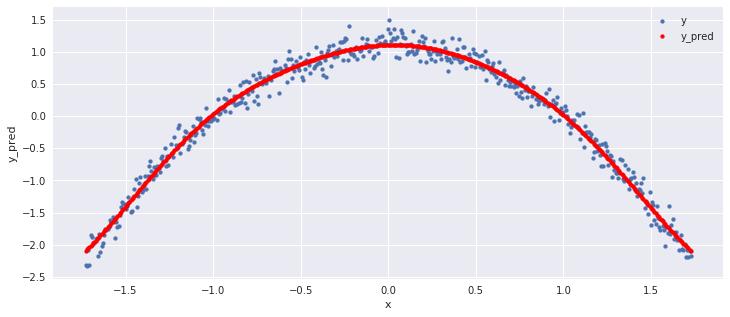

In [10]:
from sklearn.svm import SVR

reg=None
reg = SVR(C=1)

t0 = time()

reg.fit(x_train, y_train[:, 0])

print("Training Time:  \t {:.3f} s".format(time() - t0 ))


train_time = time() - t0
y_pred = reg.predict(x_test)

df_pred3 = data.copy()
df_pred3['y_pred'] = y_pred

ax = df_pred3.plot.scatter('x', 'y', figsize=(12, 5), s=15, label='y')
df_pred3.plot.scatter('x', 'y_pred', ax=ax, c='r', s=15, label='y_pred');